# **Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cvxopt
import seaborn as sns
from matplotlib.cm import ScalarMappable
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
sns.set_theme(style="whitegrid")
colors = sns.color_palette("viridis", 3)
plt.rcParams['figure.figsize'] = [10, 6]

# **Import Data**

In [3]:
# Load the Iris dataset
iris = load_iris()
X = iris.data[:, :2]  # Using only the first two features for visualization
y = iris.target

# Let's focus on a binary classification problem (setosa vs versicolor)
X = X[y != 2]
y = y[y != 2]
y = 2 * y - 1  # Convert to -1 and 1 for SVM

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# **Build Custom SVM for Classification**

In [4]:
# Define kernel functions
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, degree=3):
    return (np.dot(x1, x2) + 1) ** degree

def rbf_kernel(x1, x2, gamma=1.0):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

class SVM:
    def __init__(self, kernel=linear_kernel, C=1.0):
        self.kernel = kernel
        self.C = C  # Regularization parameter
        self.alphas = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.b = 0  # Bias term

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Compute the Gram matrix (kernel matrix)
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])

        # Set up the quadratic programming problem for CVXOPT
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-np.ones(n_samples))

        # Inequality constraints: 0 <= alpha <= C
        G = cvxopt.matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

        # Equality constraint: sum(alpha_i * y_i) = 0
        A = cvxopt.matrix(y.astype(float).reshape(1, -1))
        b = cvxopt.matrix(0.0)

        # Solve the QP problem
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Extract the Lagrange multipliers
        alphas = np.array(solution['x']).reshape(-1)

        # Find support vectors (alphas > 1e-5)
        sv_indices = alphas > 1e-5
        self.alphas = alphas[sv_indices]
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = y[sv_indices]

        # Compute the bias term
        self.b = 0
        for i in range(len(self.alphas)):
            self.b += self.support_vector_labels[i]
            self.b -= np.sum(self.alphas * self.support_vector_labels *
                            [self.kernel(self.support_vectors[i], x) for x in self.support_vectors])
        self.b /= len(self.alphas)

    def predict(self, X):
        y_pred = np.zeros(len(X))
        for i, x in enumerate(X):
            s = 0
            for alpha, sv, sv_y in zip(self.alphas, self.support_vectors, self.support_vector_labels):
                s += alpha * sv_y * self.kernel(x, sv)
            y_pred[i] = s + self.b
        return np.sign(y_pred)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

In [5]:
# Create a meshgrid for visualization
def plot_decision_boundary(svm, X, y, title, kernel_name):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Make predictions on the meshgrid
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Create a color plot with decision boundary
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

    # Plot the training points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdYlBu)

    # Highlight support vectors
    plt.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1],
                s=100, linewidth=1, facecolors='none', edgecolors='k')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'SVM with {kernel_name} Kernel\n{title}')
    plt.xlabel('Sepal length (standardized)')
    plt.ylabel('Sepal width (standardized)')
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

Training SVM with Linear Kernel...


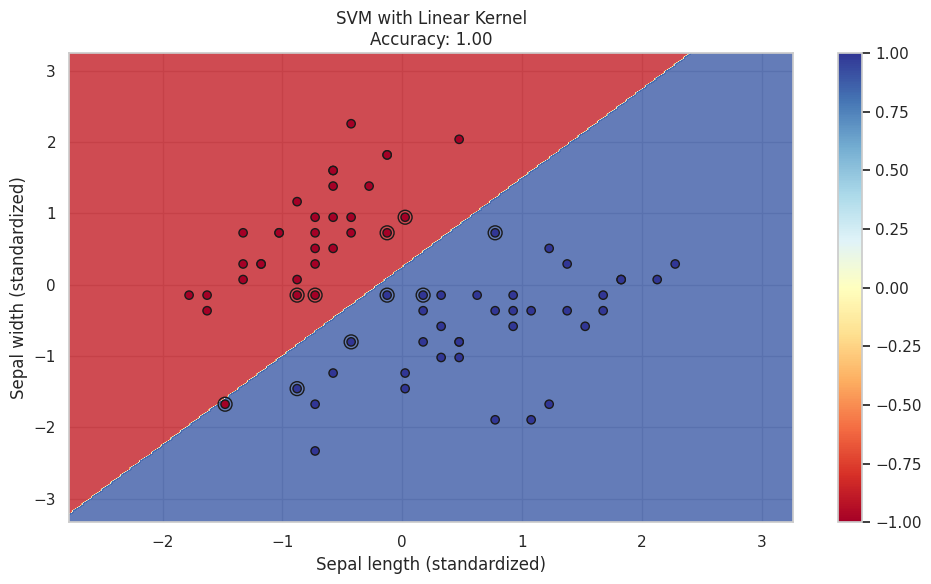

Training SVM with Polynomial Kernel...


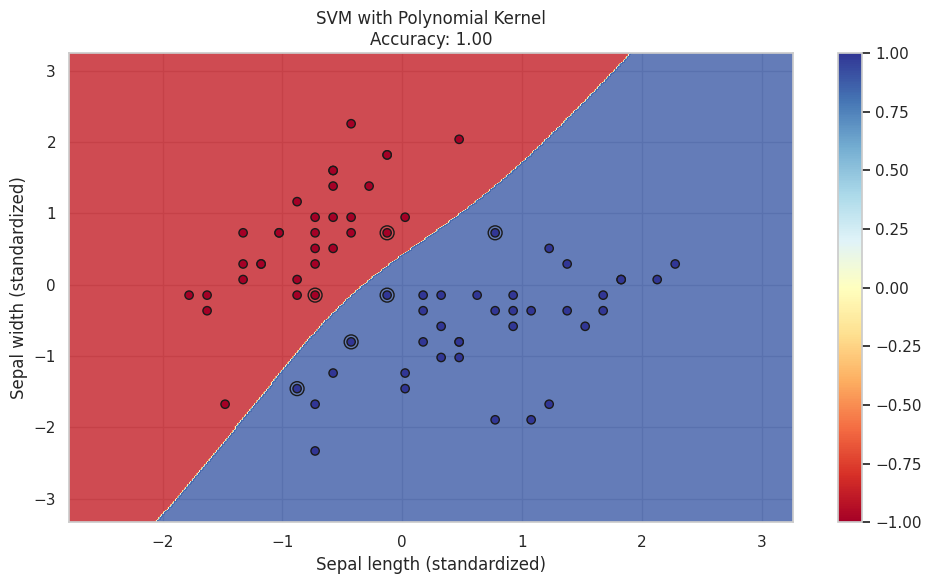

Training SVM with RBF Kernel...


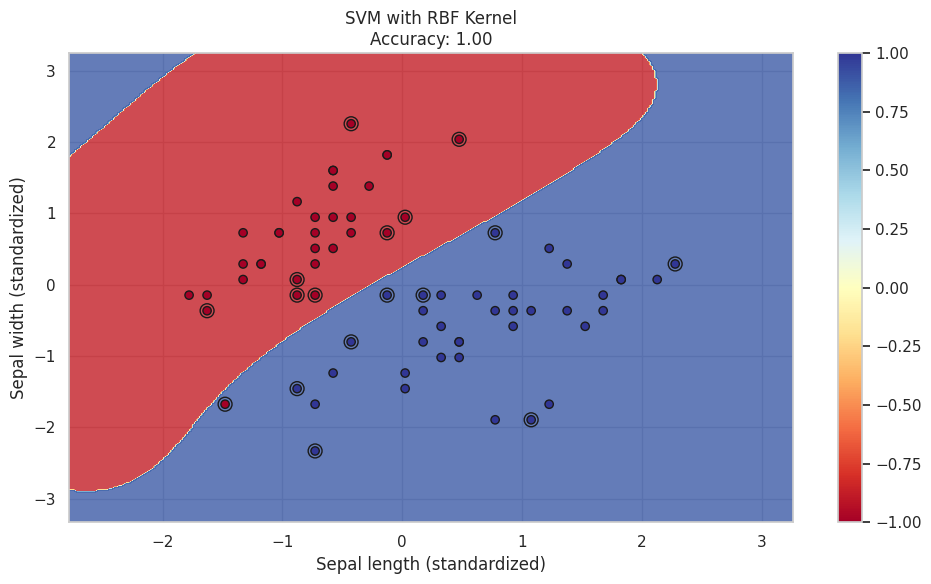

In [6]:
# Train SVM with different kernels
print("Training SVM with Linear Kernel...")
svm_linear = SVM(kernel=linear_kernel, C=1.0)
svm_linear.fit(X_train, y_train)
accuracy = svm_linear.score(X_test, y_test)
plot_decision_boundary(svm_linear, X_train, y_train, f'Accuracy: {accuracy:.2f}', 'Linear')

print("Training SVM with Polynomial Kernel...")
svm_poly = SVM(kernel=lambda x, y: polynomial_kernel(x, y, degree=3), C=1.0)
svm_poly.fit(X_train, y_train)
accuracy = svm_poly.score(X_test, y_test)
plot_decision_boundary(svm_poly, X_train, y_train, f'Accuracy: {accuracy:.2f}', 'Polynomial')

print("Training SVM with RBF Kernel...")
svm_rbf = SVM(kernel=lambda x, y: rbf_kernel(x, y, gamma=0.5), C=1.0)
svm_rbf.fit(X_train, y_train)
accuracy = svm_rbf.score(X_test, y_test)
plot_decision_boundary(svm_rbf, X_train, y_train, f'Accuracy: {accuracy:.2f}', 'RBF')



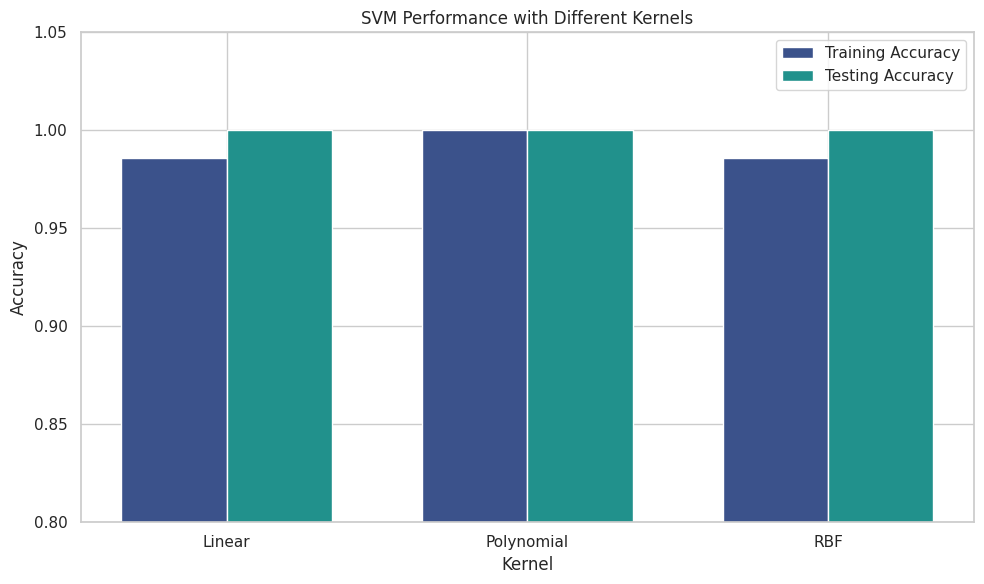

In [7]:
# Compare performance of different kernels
kernels = ['Linear', 'Polynomial', 'RBF']
train_scores = [
    svm_linear.score(X_train, y_train),
    svm_poly.score(X_train, y_train),
    svm_rbf.score(X_train, y_train)
]
test_scores = [
    svm_linear.score(X_test, y_test),
    svm_poly.score(X_test, y_test),
    svm_rbf.score(X_test, y_test)
]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(kernels))

plt.bar(index, train_scores, bar_width, label='Training Accuracy', color=colors[0])
plt.bar(index + bar_width, test_scores, bar_width, label='Testing Accuracy', color=colors[1])

plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.title('SVM Performance with Different Kernels')
plt.xticks(index + bar_width/2, kernels)
plt.legend()
plt.ylim(0.8, 1.05)  # Adjust as needed
plt.tight_layout()
plt.show()

# **Build SVM for Regression**

In [21]:
sns.set_theme(style="whitegrid")
colors = sns.color_palette("viridis", 4)
plt.rcParams['figure.figsize'] = [12, 7]

In [22]:
# Suppress CVXOPT output
cvxopt.solvers.options['show_progress'] = False

In [23]:
# Load the Boston Housing dataset
california = fetch_california_housing()
X = california.data
y = california.target

In [31]:
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.1, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)



(1651, 8) (413, 8)


In [32]:
# Standardize the features and target
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [33]:
# Define kernel functions
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, degree=3):
    return (np.dot(x1, x2) + 1) ** degree

def rbf_kernel(x1, x2, gamma=1.0):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

class SVR:
    def __init__(self, kernel=linear_kernel, C=1.0, epsilon=0.1):
        self.kernel = kernel
        self.C = C  # Regularization parameter
        self.epsilon = epsilon  # Epsilon in the epsilon-tube
        self.alphas = None  # Lagrange multipliers (alpha - alpha*)
        self.support_vectors = None
        self.support_vector_y = None
        self.b = 0  # Bias term

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Compute the Gram matrix (kernel matrix)
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])

        # Set up the quadratic programming problem for CVXOPT
        # We need to solve for both alpha and alpha* (for epsilon-insensitive loss)
        # P is the quadratic term, q is the linear term in the objective function
        P = cvxopt.matrix(np.block([
            [K, -K],
            [-K, K]
        ]))
        q = cvxopt.matrix(np.hstack([
            self.epsilon - y,
            self.epsilon + y
        ]))

        # Inequality constraints: 0 <= alpha, alpha* <= C
        G = cvxopt.matrix(np.vstack([
            -np.eye(2*n_samples),  # -alpha, -alpha* <= 0
            np.eye(2*n_samples)    # alpha, alpha* <= C
        ]))
        h = cvxopt.matrix(np.hstack([
            np.zeros(2*n_samples),
            np.ones(2*n_samples) * self.C
        ]))

        # Equality constraint: sum(alpha - alpha*) = 0
        A = cvxopt.matrix(np.hstack([
            np.ones(n_samples),
            -np.ones(n_samples)
        ]).reshape(1, -1))
        b = cvxopt.matrix(0.0)

        # Solve the QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Extract the Lagrange multipliers
        alphas = np.array(solution['x']).reshape(-1)
        alpha = alphas[:n_samples]
        alpha_star = alphas[n_samples:]

        # Compute the effective alphas (alpha - alpha*)
        effective_alphas = alpha - alpha_star

        # Find support vectors (points where |effective_alphas| > 1e-5)
        sv_indices = np.abs(effective_alphas) > 1e-5
        self.effective_alphas = effective_alphas[sv_indices]
        self.support_vectors = X[sv_indices]
        self.support_vector_y = y[sv_indices]

        # Compute the bias term
        self.b = 0
        for i in range(len(self.effective_alphas)):
            self.b += self.support_vector_y[i]
            self.b -= self.epsilon * np.sign(self.effective_alphas[i])
            self.b -= np.sum(self.effective_alphas *
                           [self.kernel(self.support_vectors[i], x) for x in self.support_vectors])

        if len(self.effective_alphas) > 0:
            self.b /= len(self.effective_alphas)

    def predict(self, X):
        y_pred = np.zeros(len(X))
        for i, x in enumerate(X):
            s = 0
            for alpha, sv in zip(self.effective_alphas, self.support_vectors):
                s += alpha * self.kernel(x, sv)
            y_pred[i] = s + self.b
        return y_pred


Training SVR with Linear Kernel...
Training SVR with Polynomial (degree=2) Kernel...
Training SVR with RBF (gamma=5.0) Kernel...


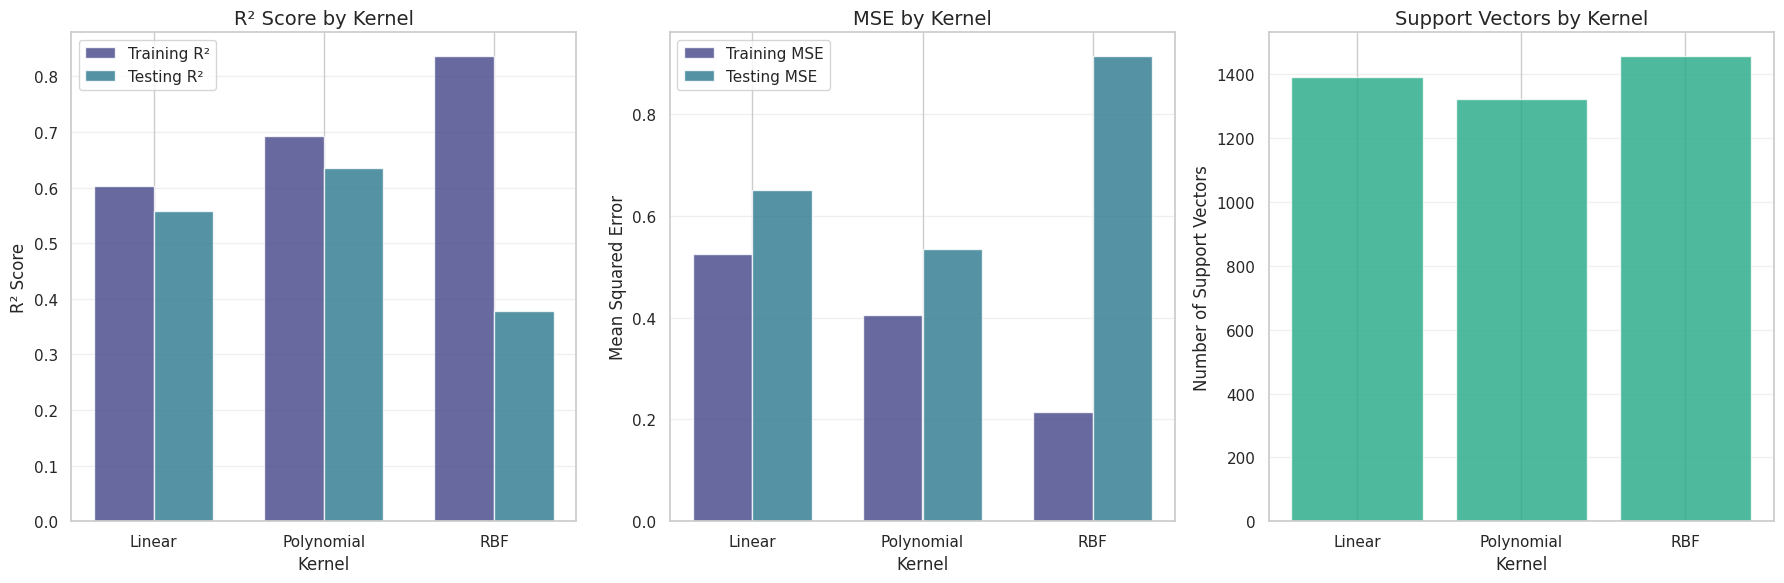

In [34]:
# Train SVR with different kernels
def train_and_visualize(kernel_func, kernel_name, param_name=None, param_value=None):
    # Create SVR instance
    if param_name and param_value:
        svr = SVR(kernel=lambda x, y: kernel_func(x, y, param_value), C=1.0, epsilon=0.1)
        kernel_display = f"{kernel_name} ({param_name}={param_value})"
    else:
        svr = SVR(kernel=kernel_func, C=1.0, epsilon=0.1)
        kernel_display = kernel_name

    # Fit the model
    print(f"Training SVR with {kernel_display} Kernel...")
    svr.fit(X_train_scaled, y_train_scaled)

    # Make predictions
    y_train_pred = svr.predict(X_train_scaled)
    y_test_pred = svr.predict(X_test_scaled)

    # Transform predictions back to original scale
    y_train_pred_orig = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
    y_test_pred_orig = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred_orig)
    test_mse = mean_squared_error(y_test, y_test_pred_orig)
    train_r2 = r2_score(y_train, y_train_pred_orig)
    test_r2 = r2_score(y_test, y_test_pred_orig)

    return train_r2, test_r2, train_mse, test_mse, len(svr.support_vectors)

# Train models with different kernels
results = []

# Linear kernel
train_r2, test_r2, train_mse, test_mse, n_sv = train_and_visualize(linear_kernel, "Linear")
results.append(["Linear", train_r2, test_r2, train_mse, test_mse, n_sv])

# Polynomial kernel
train_r2, test_r2, train_mse, test_mse, n_sv = train_and_visualize(polynomial_kernel, "Polynomial", "degree", 2)
results.append(["Polynomial", train_r2, test_r2, train_mse, test_mse, n_sv])

# RBF kernel
train_r2, test_r2, train_mse, test_mse, n_sv = train_and_visualize(rbf_kernel, "RBF", "gamma", 5.0)
results.append(["RBF", train_r2, test_r2, train_mse, test_mse, n_sv])

# Visualize comparison of kernels
def plot_comparison(results):
    kernels, train_r2, test_r2, train_mse, test_mse, n_sv = zip(*results)

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # R² comparison
    bar_width = 0.35
    index = np.arange(len(kernels))

    ax1.bar(index, train_r2, bar_width, label='Training R²', color=colors[0], alpha=0.8)
    ax1.bar(index + bar_width, test_r2, bar_width, label='Testing R²', color=colors[1], alpha=0.8)
    ax1.set_xlabel('Kernel', fontsize=12)
    ax1.set_ylabel('R² Score', fontsize=12)
    ax1.set_title('R² Score by Kernel', fontsize=14)
    ax1.set_xticks(index + bar_width/2)
    ax1.set_xticklabels(kernels)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # MSE comparison
    ax2.bar(index, train_mse, bar_width, label='Training MSE', color=colors[0], alpha=0.8)
    ax2.bar(index + bar_width, test_mse, bar_width, label='Testing MSE', color=colors[1], alpha=0.8)
    ax2.set_xlabel('Kernel', fontsize=12)
    ax2.set_ylabel('Mean Squared Error', fontsize=12)
    ax2.set_title('MSE by Kernel', fontsize=14)
    ax2.set_xticks(index + bar_width/2)
    ax2.set_xticklabels(kernels)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # Number of support vectors
    ax3.bar(index, n_sv, color=colors[2], alpha=0.8)
    ax3.set_xlabel('Kernel', fontsize=12)
    ax3.set_ylabel('Number of Support Vectors', fontsize=12)
    ax3.set_title('Support Vectors by Kernel', fontsize=14)
    ax3.set_xticks(index)
    ax3.set_xticklabels(kernels)
    ax3.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot comparison
plot_comparison(results)